In [1]:
import LightGraphs; const lg = LightGraphs
import GraphPlot; const gp = GraphPlot
import MetaGraphs; const mg = MetaGraphs
import LinearAlgebra; const la = LinearAlgebra
import Combinatorics; const cmb = Combinatorics
import Random; const rnd = Random

Random

# Irreducible case

In [132]:
function IsInjective(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
    #=
    G, H are irreducible (i.e. strongly connected) digraphs.
    k=1 case
    Take some vertex map Ψ, test if Ψ_c is bijective
    =#
    
    ## Construct meta graph
    # note: meta_vertices is a list of pairs of vertices from G, but 
    # meta_edges is a list of vertex indices, i.e. if (v_i,u_j) is the 10th element
    # of meta_vertices and (v_k,u_l) the 100th, then the edge between them is (10,100)
    # not ((v_i,u_j), (v_k, u_l)) as it would be mathematically. This fixed order list is
    # a bit dangerous but the best solution I have rn. A (partial) resolution is to use metagraphs
    # where the name of each vertex is the tuple from GxG to which it corresponds. Alternative is to use dictionaries
    
    nvertices_G = lg.nv(G) 
    M = mg.MetaDiGraph(nvertices_G^2)
    
    meta_vertices = enumerate([(a,b) for a in lg.vertices(G), b in lg.vertices(G)])
    for (idv,v) in meta_vertices
        mg.set_prop!(M,idv,:name,v)
    end
    
    meta_edges = []
    for (idv,v) in meta_vertices, (idu, u) in meta_vertices
        v_1, v_2 = v
        u_1, u_2 = u
        # check conditions from Shrock pg 46
        if Ψ[v_1]==Ψ[v_2] && Ψ[u_1] == Ψ[u_2] && lg.has_edge(G, (v_1,u_1)) && lg.has_edge(G, (v_2,u_2))
            push!(meta_edges, (idv,idu)) 
        end
    end
    for e in meta_edges
        lg.add_edge!(M, e)
    end

    ## Get the strongly connected commponents 
    # ψ_c is inject iff they consist of either of singleton sets or sets of vertices of the form (v,v)
    S = lg.strongly_connected_components(M) # counts vertices with no edges as their own ssc, but that does not matter
    for s in S
        if length(s) == 1
            continue
        else 
            for v in s
                v_1, v_2 = mg.get_prop(M,v,:name) # get vertices from G which make up v
                if v_1 != v_2
                    print("$v_1 ≢ $v_2 in SSC of meta graph")
                    return false
                end
            end 
        end
    end
    return true
end

IsInjective (generic function with 1 method)

## Testing Injectivity
Test on example from Shrock fig 2.4 

In [25]:
A = [
    1 1 0
    1 0 1 
    1 0 1
]
B = [
    1 1
    1 1
]
G = lg.DiGraph(A)
H = lg.DiGraph(B)

Dict{Int64,Int64} with 3 entries:
  2 => 2
  3 => 2
  1 => 1

In [27]:
Ψ = Dict(1 => 2, 2=>2, 3=>2)
IsInjective(G,H,Ψ)

false

In [28]:
Ψ = Dict(1 => 1, 2=>2, 3=>2)
IsInjective(G,H,Ψ)

true

Test from Shrock fig 2.6

In [29]:
A2 = [
    0 1 0 0 0
    0 1 1 0 0
    0 0 0 1 1
    1 0 0 0 1
    0 0 1 0 0
]
B2 = [
    0 1
    1 0
]
G2 = lg.DiGraph(A2)
H2 = lg.DiGraph(B2)

{2, 2} directed simple Int64 graph

In [35]:
Ψ = Dict(1 => 2, 2=>2, 3=>1, 4=>2,5=>2)
IsInjective(G2,H2,Ψ)

true

Success!

# Full Irreducible Case

In [127]:
function IsConjugacyIrreducible(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
    #=
    Takes in two irreducible grpahs and a vetex map Ψ and decides if the induced 1-block code
    is a conjugacy
    =#
    
    # injectivity
    if !IsInjective(G,H,Ψ)
        print("1-block code not injective!")
        return false
    end
    # surjectivity
    A_G = lg.adjacency_matrix(G)
    A_H = lg.adjacency_matrix(H)
    for i in lg.nv(G)
        if la.tr(A_G^i) != la.tr(A_H^i)
            print("1-block code not surjective!")
            return false
        end
    end
    return true
end

IsConjugacyIrreducible (generic function with 1 method)

In [45]:
A = [
    1 1 0
    1 0 1 
    1 0 1
]
B = [
    1 1
    1 1
]
G = lg.DiGraph(A)
H = lg.DiGraph(B)

{2, 4} directed simple Int64 graph

In [47]:
Ψ = Dict(1 => 1, 2=>2, 3=>2)
IsConjugacyIrreducible(G,H,Ψ)

true

# Need an implementation of BFS

In [2]:
function bfs_path(G::T, v::Int, S::Array{U,1}; returnpath=true) where {T<:lg.AbstractGraph, U<:Int}
    #=
    G is a graph (directed or not), v is a vertex from G, and S is an array of vertices from G which serves as a stopping condition.
    If returnpath=false, returns true if there is a path and false otherwise.
    If returnpath=true, returns the path if there is one and nothing otherwise.
    =#
    Q = [[v]] 
    D = [v]
    while length(Q)>0
        path = popat!(Q,1)
        endpoint = last(path)
        for u in lg.outneighbors(G,endpoint)
            if u in S
                if returnpath
                    return path
                else
                    return true
                end
            elseif !in(u,D)
                push!(D,u)
                newpath = copy(path)
                push!(newpath,u)
                push!(Q,newpath)
            end
        end
    end
    if !returnpath
        return false
    end
end

bfs_path (generic function with 1 method)

# Reducible Case

In [84]:
function AddSinkComponents!(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
    #=
    Takes in reducible G and H and vertex map Ψ. Modifies G, H, and Ψ so that the preimage of each sink component 
    under Ψ has 1 vertex in such a way as to preserve/not preserve conjugacy. 
    
    Input
    G,H: Reducible vertex shifts
    Ψ: 1 block code
    
    Output
    Modified G,H,Ψ
    =#
    
    # get sink components
    T = lg.attracting_components(H)
    for sink_vertices in T
        sink, = lg.induced_subgraph(H,sink_vertices) # sink vertices are from H but get relabeled in sink
        
        # get preimage of sink
        presink_vertices = Int[]
        for v in lg.vertices(G)
            if Ψ[v] in sink_vertices
                push!(presink_vertices, v)
            end
        end

        presink, = lg.induced_subgraph(G, presink_vertices) 
        if length(presink_vertices)==1
            continue
        end

        ## Construct subgraphs cyclic and precyclic
        special_v = rnd.rand(lg.vertices(sink)) #sink_vertices) # pick from H # get random vertex ## debug: equal 1
        special_v_H = sink_vertices[special_v]
        # can use special_vertices to map between them as special_vertices[special_v] \in V_H.
        
        # find shortest cycle in sink starting at v with BFS
        # Note: shortest_cycle is the vertex set for cyclic
        shortest_cycle = bfs_path(sink,special_v, [special_v])
        shortest_cycle_H = [sink_vertices[v] for v in shortest_cycle] # convert shortest cycle to names in H
        
        # E_c is all words of length two in shortest_cycle
        # I want cyclic and precyclic to be subsets of H and G respectively
        cyclic_edges = []
        if length(shortest_cycle_H)==1
            push!(cyclic_edges,(special_v_H,special_v_H))
        else
            for i in 1:(length(shortest_cycle_H)-1)
                push!(cyclic_edges, (shortest_cycle_H[i], shortest_cycle_H[i+1]))
            push!(cyclic_edges,(last(shortest_cycle_H),shortest_cycle_H[1])) # make sure to wrap around
            end
        end

        #---
        precyclic_vertices = Int[]
        for v in presink_vertices #\subset G
            if Ψ[v] in shortest_cycle_H  #\subset H
                push!(precyclic_vertices, v)
            end
        end
        precyclic_edges = []
        for v in presink_vertices, u in presink_vertices #\subset G
            if (Ψ[v], Ψ[u]) in cyclic_edges # \subset H
                push!(precyclic_edges, (v,u))
            end
        end
        
        # construct a Julia graph for precyclic for the sake of finding paths
        new_vertex_names_precyclic = Dict([(old,new) for (new,old) in enumerate(precyclic_vertices)]) # maps vertices in G to their new name in precyclic
        precyclic = lg.DiGraph(length(precyclic_vertices))
        for e in precyclic_edges
            e_1, e_2 = e
            lg.add_edge!(precyclic, (new_vertex_names_precyclic[e_1], new_vertex_names_precyclic[e_2]))
        end
        # get all vertices lying on cycles 
        cyclic_vertices = Int[]
        for cyc in lg.simplecycles(precyclic)
            cyclic_vertices = vcat(cyclic_vertices, cyc)
        end
        unique!(cyclic_vertices)
        
        ##Add new vertices/edges to G and H
        # H
        lg.add_vertex!(H) #t
        t = length(lg.vertices(H)) 
        lg.add_edge!(H, t, t)
        lg.add_edge!(H, special_v_H, t) # what is v?
        
        # G
        lg.add_vertex!(G)
        pre_t = length(lg.vertices(G)) 
        lg.add_edge!(G, pre_t, pre_t)
        for v in lg.vertices(precyclic) #\subset G 
            v_G = precyclic_vertices[v] # get name in G
            if bfs_path(precyclic,v,cyclic_vertices; returnpath=false) && Ψ[v_G]==special_v_H
                lg.add_edge!(G, (v_G,pre_t))
            end 
        end
        
        ## Update Ψ
        Ψ[pre_t] = t    
    end
end

AddSinkComponents! (generic function with 1 method)

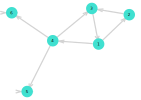

In [109]:
H = lg.DiGraph(
    [0 1 0 1 0
     0 0 1 0 0
     1 0 0 0 0
     0 0 1 0 1
     0 0 0 0 1])
G = lg.DiGraph(
    [0 1 0 1 0 0
     0 0 1 0 0 0
     1 0 0 0 0 0
     0 0 1 0 1 1
     0 0 0 0 1 0
     0 0 0 0 0 1])
Ψ = Dict(1=>1,2=>2,3=>3,4=>4,5=>5,6=>5)
gp.gplot(G,nodelabel=1:6)

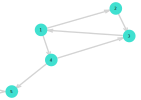

In [110]:
gp.gplot(H,nodelabel=1:5)

In [111]:
AddSinkComponents!(G,H,Ψ)

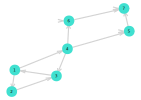

In [114]:
gp.gplot(G,nodelabel=1:7)

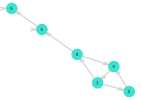

In [113]:
gp.gplot(H,nodelabel=1:6)

I am a god

In [115]:
function AddSourceComponents!(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
    lg.reverse!(G)
    lg.reverse!(H)
    AddSinkComponents!(G,H,Ψ)
    lg.reverse!(G)
    lg.reverse!(H)
end

AddSourceComponents! (generic function with 1 method)

In [116]:
AddSourceComponents!(G,H,Ψ)

{7, 11} directed simple Int64 graph

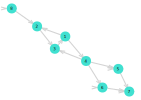

In [117]:
gp.gplot(G,nodelabel=1:length(lg.vertices(G)))

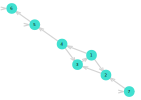

In [118]:
gp.gplot(H,nodelabel=1:length(lg.vertices(H)))

Yes!!!!

# Full Algorithm (for connected graphs)

In [131]:
function IsConjugacyReducible!(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
    #=
    Input
    G,H: Reducible Graphs
    Ψ: 1-block code
    
    Output
    bool: true if Ψ is a conjugacy; false otherwise
    =#
    
    AddSinkComponents!(G,H,Ψ)
    AddSourceComponents!(G,H,Ψ)
    
    # add vertex * and new edges to G
    T = lg.attracting_components(G)
    S = lg.attracting_components(lg.reverse(G)) #source components
    lg.add_vertex!(G)
    star = length(lg.vertices(G))
    for t in T
        lg.add_edge!(G,(t[1],star)) # source and sink components should be singleton sets
    end
    for s in S
        lg.add_edge!(G,(star,s[1]))
    end
    
    # add vertex * and new edges to H
    T = lg.attracting_components(H)
    S = lg.attracting_components(lg.reverse(H)) #source components
    lg.add_vertex!(H)
    star2 = length(lg.vertices(H))
    for t in T
        lg.add_edge!(H, (t[1],star2))
    end
    for s in S
        lg.add_edge!(H,(star2,s[1]))
    end
    
    # Update Ψ
    Ψ[star]=star2
    
    return IsConjugacyIrreducible(G,H,Ψ)
end

IsConjugacyReducible! (generic function with 1 method)

## Test for full reducible code

In [157]:
G = lg.DiGraph([
        1 1 1 0 0 0 0
        0 0 0 0 0 0 1
        0 0 0 1 0 0 0
        0 1 0 0 1 0 0
        0 0 0 0 0 1 0
        0 0 0 0 1 0 0 
        0 0 0 1 0 0 0
    ])
H = lg.DiGraph([
        1 1 1 0 0 0 
        0 0 1 0 0 0 
        0 0 0 1 0 0 
        0 1 0 0 1 0 
        0 0 0 0 0 1 
        0 0 0 0 1 0  
        ])
Ψ = Dict(1=>1,2=>2,3=>3,4=>4,5=>5,6=>6,7=>3) # amalgamate 3 and 7

Dict{Int64,Int64} with 7 entries:
  7 => 3
  4 => 4
  2 => 2
  3 => 3
  5 => 5
  6 => 6
  1 => 1

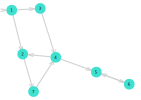

In [142]:
gp.gplot(G,nodelabel=1:7)

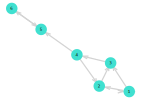

In [143]:
gp.gplot(H,nodelabel=1:6)

In [144]:
IsConjugacyReducible!(G,H,Ψ) # Ψ collapes a diamond, so can't be conjugacy

true

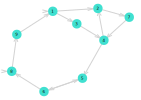

In [152]:
gp.gplot(G,nodelabel=1:length(lg.vertices(G)))

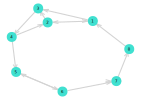

In [149]:
gp.gplot(H,nodelabel=1:length(lg.vertices(H)))

# Full Code (all cases)

In [155]:
function IsConjugacy(G::lg.AbstractGraph, H::lg.AbstractGraph, Ψ::Dict)
   #=
    Input
    G,H: Vertex shifts
    Ψ: 1-block code
    
    Output
    bool: true if Ψ is a conjugacy; false otherwise
    =#
    
    # make copies so as to preserve the original graphs
    G = copy(G)
    H = copy(H)
    Ψ = copy(Ψ)
    # are G and H both irreducible?
    if lg.is_strongly_connected(G) && lg.is_strongly_connected(H)
        return IsConjugacyIrreducible(G,H,Ψ)
    # are G and H both reducible?
    elseif !lg.is_strongly_connected(G) && !lg.is_strongly_connected(H)
        return IsConjugacyReducible!(G,H,Ψ)
    # if one is reducible and the other not, can't be conjugate via 1-block conjugacy
    else
        return false
    end
end

IsConjugacy (generic function with 1 method)

In [158]:
IsConjugacy(G,H,Ψ)

true